# Introduction

Medical Engineering is a field comprehending the fusion of health science, computer science, signal processing, and robotics. Currently, I am inclined to research in health engineering and am starting my first Python experimentation project on __pneumonia classification__ using CNN.

### Note on the metric

In medical field missing a true positive (eg: a disease or condition) can have detrimental consequences, so the emphasis should be put on _Recall_.

## Imports

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
%matplotlib inline

In [2]:
print(torch.__version__)

2.1.0+cu121


## Constants

Select the device to use for training and inference.

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

Other constants

In [4]:
DATA_DIR = Path("../data/chest_xray/")
MODEL_DIR = Path("../models/")
PLOT_DIR = Path("../plots/")

In [5]:
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001

## Data Processes

### Data Augmentation (Transforms)

In [6]:
from torchvision import transforms

In [7]:
transform = transforms.Compose([
    # transforms.ToImage(),
    transforms.Resize(IMAGE_SIZE),  # Resize images to a common size
    # transforms.Grayscale(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize to mean 0 and standard deviation 1
])

## Loading the dataset

In [8]:
training_dataset = torchvision.datasets.ImageFolder(
    root = DATA_DIR/ "train",
    transform = transform
)

In [9]:
val_dataset = torchvision.datasets.ImageFolder(
    root = DATA_DIR / "val",
    transform = transform,
)

In [10]:
test_dataset = torchvision.datasets.ImageFolder(
    root = DATA_DIR / "test",
    transform = transform,
)

### Check if dataset if properly loaded

In [11]:
def show_batch(image_batch, label_batch, image_classes):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(image_classes[label_batch[n]])
        plt.axis("off")

In [12]:
image_batch, label_batch, image_classes = *next(iter(DataLoader(training_dataset, batch_size=25, shuffle=True))), training_dataset.classes

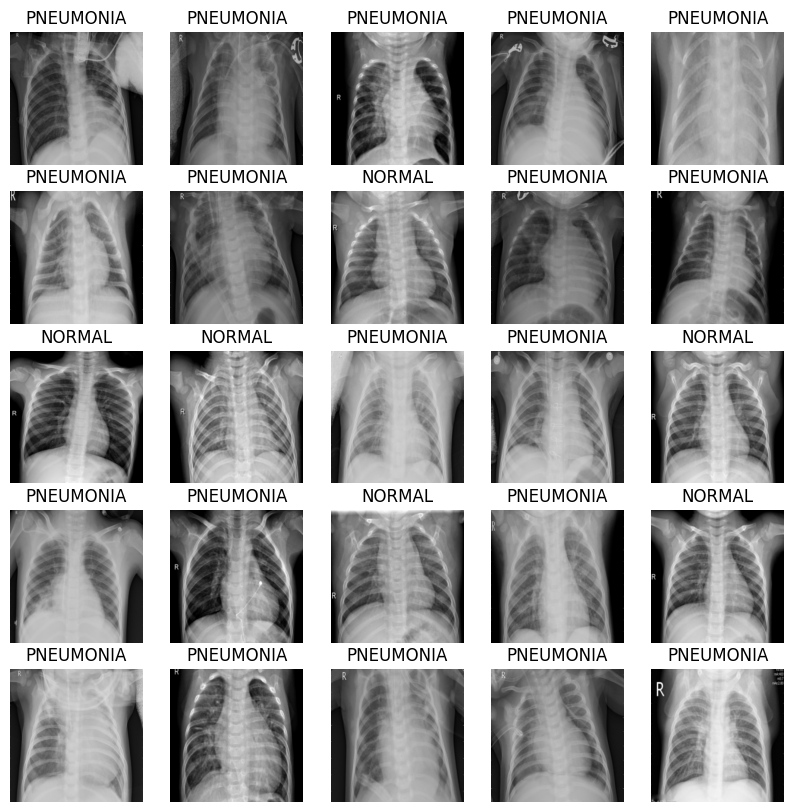

In [13]:
show_batch(image_batch.permute(0, 2, 3, 1), label_batch.numpy(), image_classes)

### Check for data imbalance

In [14]:
# Get the label counts
training_label_count = (pd.Series(training_dataset.targets).value_counts()).sort_index()
validation_label_count = (pd.Series(val_dataset.targets).value_counts()).sort_index()
test_label_count = (pd.Series(test_dataset.targets).value_counts()).sort_index()

In [15]:
training_label_count

0    1341
1    3875
Name: count, dtype: int64

In [16]:
def plot_label_counts(dataset_count, dataset_type):
    plt.bar(dataset_count.index, dataset_count.values, color=["blue", "orange"])
    plt.xticks(range(len(dataset_count.index)), ['Normal(0)', 'Pneumonia(1)'])
    plt.title(f"Dataset: {dataset_type}")
    plt.xlabel("Label")
    plt.ylabel("Count of samples")
    plt.show()

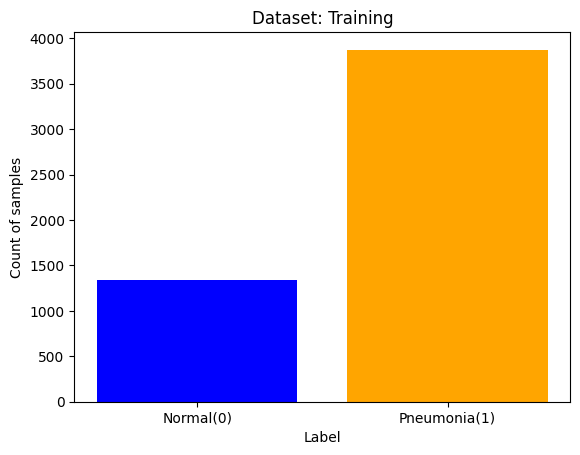

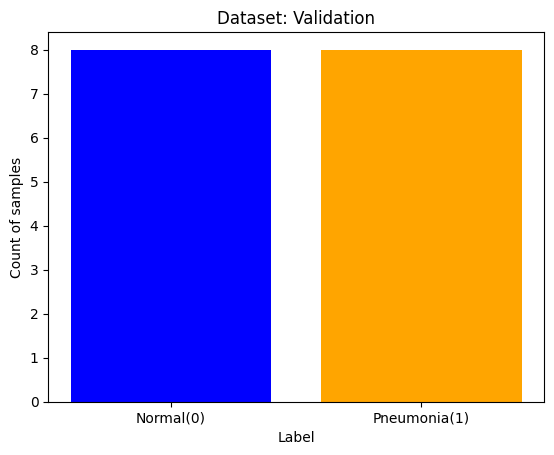

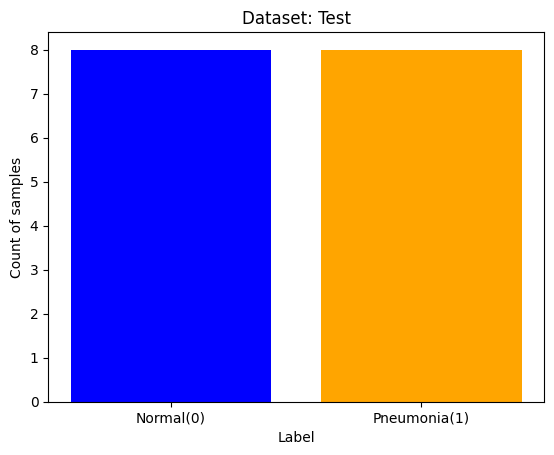

In [17]:
plot_label_counts(training_label_count, "Training")
plot_label_counts(validation_label_count, "Validation")
plot_label_counts(validation_label_count, "Test")

Got the label count, data is imbalanced but not in the conventional way. 
- For training dataset: _The positive classes are in larger number than the negative one_.
- For Validation/test dataset: The dataset is balanced.

_In the another iteration of the notebook, we will deal with unbalanced dataset._

### Instantiate the DataLoader object

In [18]:
training_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Define the model

Let's resort to using simple CNN architecture.

In [19]:
import torch.nn as nn

In [20]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(128*28*28, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.conv_block_1(x))
        x = self.pool(self.conv_block_2(x))
        x = self.pool(self.conv_block_3(x))
        x = x.view(x.size(0), -1)
        x = self.sigmoid(self.fc(x))
        return x

In [21]:
# instantiate the model
model = BasicCNN().to(DEVICE)

In [22]:
model

BasicCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block_3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=100352, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Training the model


### Utility functions

In [25]:
from tqdm import tqdm

In [86]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, '../models/model.pth')

In [89]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('../plots/accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../plots/loss.png')

In [142]:
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.float().to(device)
        # weights = torch.where(labels==1, POS_WEIGHT, NEG_WEIGHT).unsqueeze(1).to(device)
        labels = labels.unsqueeze(1).float().to(device)
        
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(image).float()
        # calculate the loss
        loss = criterion(outputs, labels)
        # loss = (loss * weights).mean()
        train_running_loss += loss.item()
        
        # calculate the accuracy
        # _, preds = torch.max(outputs.data, 0)
        preds = outputs.round()
        train_running_correct += (preds.squeeze() == labels.squeeze()).sum().item()
        
        # backpropagation
        loss.backward()
        
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    print(train_running_correct)
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [143]:
# validation
def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.float().to(device)
            # weights = torch.where(labels==1, POS_WEIGHT, NEG_WEIGHT).unsqueeze(1).to(device)
            
            labels = labels.unsqueeze(1).float().to(device)
            
            # forward pass
            outputs = model(image).float()
            # calculate the loss
            loss = criterion(outputs, labels)
            # loss = (loss * weights).mean()
            valid_running_loss += loss.item()
            
            # calculate the accuracy
            # _, preds = torch.max(outputs.data, 1)
            preds = outputs.round()
            valid_running_correct += (preds.squeeze() == labels.squeeze()).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

### Get the required params for training

#### Correction for data imbalance

In [82]:
# compute the weights 
num_classes = len(training_dataset.classes)
total_samples = training_label_count.sum()

NEG_WEIGHT = total_samples / (num_classes * training_label_count[0])
POS_WEIGHT = total_samples / (num_classes * training_label_count[1])

# weight = torch.tensor([neg_weight, pos_weight])

In [1]:
NEG_WEIGHT, POS_WEIGHT

NameError: name 'NEG_WEIGHT' is not defined

In [84]:
criterion = nn.BCELoss(reduction="none")
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay = 0.005, momentum = 0.9)
total_train_step = len(training_loader)

In [85]:
# training loop

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, training_loader, 
                                              optimizer, criterion, DEVICE)
    valid_epoch_loss, valid_epoch_acc = validate(model, validation_loader,  
                                                 criterion, DEVICE)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:39<00:00,  1.95s/it]


4664
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 1.122, training acc: 89.417
Validation loss: 3.384, validation acc: 62.500
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:34<00:00,  1.89s/it]


5018
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.180, training acc: 96.204
Validation loss: 0.103, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:31<00:00,  1.85s/it]


5052
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.116, training acc: 96.856
Validation loss: 1.591, validation acc: 68.750
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:31<00:00,  1.85s/it]


5135
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.052, training acc: 98.447
Validation loss: 0.974, validation acc: 81.250
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:30<00:00,  1.83s/it]


5050
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.127, training acc: 96.817
Validation loss: 1.840, validation acc: 81.250
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.73s/it]


5107
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.089, training acc: 97.910
Validation loss: 0.824, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:33<00:00,  1.87s/it]


5121
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.052, training acc: 98.179
Validation loss: 2.890, validation acc: 68.750
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:08<00:00,  1.57s/it]


5143
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.040, training acc: 98.600
Validation loss: 0.035, validation acc: 100.000
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:09<00:00,  1.58s/it]


5177
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.023, training acc: 99.252
Validation loss: 0.725, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:07<00:00,  1.56s/it]


5183
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.015, training acc: 99.367
Validation loss: 0.468, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:08<00:00,  1.56s/it]


5204
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.008, training acc: 99.770
Validation loss: 0.004, validation acc: 100.000
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:07<00:00,  1.55s/it]


5214
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.003, training acc: 99.962
Validation loss: 0.212, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:09<00:00,  1.58s/it]


5214
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.002, training acc: 99.962
Validation loss: 0.126, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it]


5213
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.002, training acc: 99.942
Validation loss: 0.149, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:23<00:00,  1.75s/it]


5216
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.001, training acc: 100.000
Validation loss: 0.126, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:37<00:00,  1.92s/it]


5216
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.001, training acc: 100.000
Validation loss: 0.063, validation acc: 100.000
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:25<00:00,  1.77s/it]


5216
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.001, training acc: 100.000
Validation loss: 0.102, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:19<00:00,  1.70s/it]


5216
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.001, training acc: 100.000
Validation loss: 0.076, validation acc: 100.000
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:16<00:00,  1.66s/it]


5216
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.001, training acc: 100.000
Validation loss: 0.099, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [02:19<00:00,  1.70s/it]


5216
Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]

torch.Size([16, 1]) torch.Size([16, 1])
Training loss: 0.001, training acc: 100.000
Validation loss: 0.191, validation acc: 93.750
--------------------------------------------------


RuntimeError: Parent directory ../outputs does not exist.

TRAINING COMPLETE


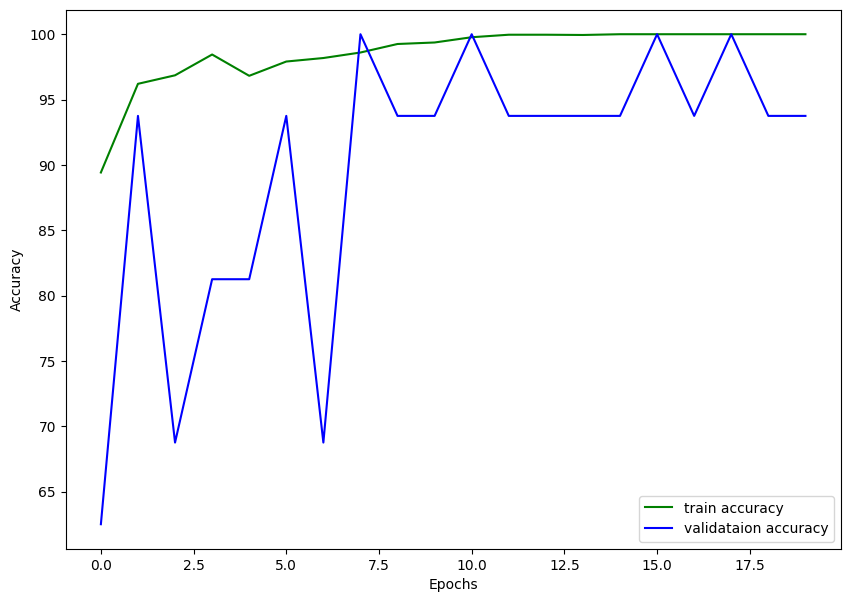

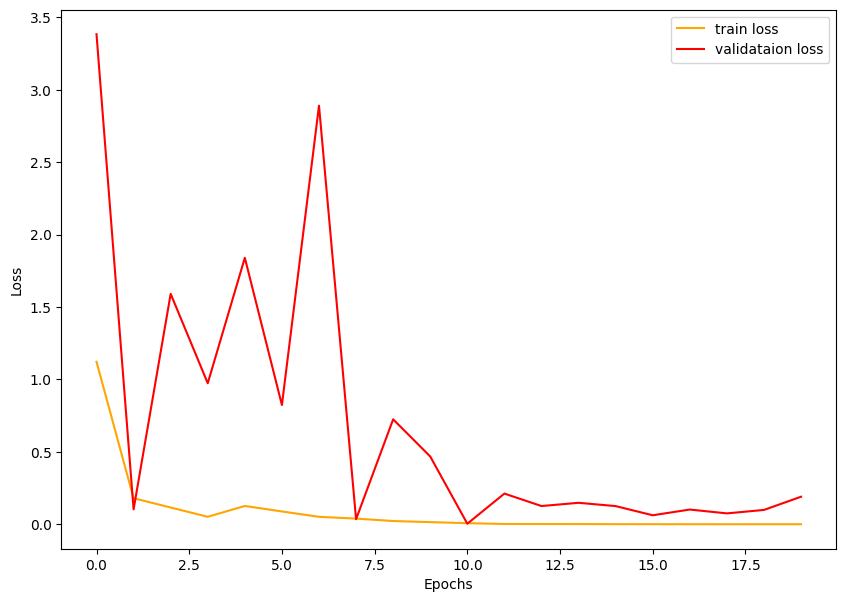

In [90]:
# save the trained model weights
save_model(EPOCHS, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

### Testing

In [118]:
!pip install scikit-learn

  Using cached scikit_learn-1.3.1-cp310-cp310-win_amd64.whl (9.3 MB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)
  Using cached scipy-1.11.3-cp310-cp310-win_amd64.whl (44.1 MB)



[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [139]:
from sklearn.metrics import classification_report, balanced_accuracy_score

In [109]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [129]:
total_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        weights = torch.where(labels==1, POS_WEIGHT, NEG_WEIGHT).unsqueeze(1).to(DEVICE)
        
        outputs = model(inputs.to(DEVICE))
        labels = labels.unsqueeze(1).float().to(DEVICE)
        loss = criterion(outputs, labels)
        loss = (weights * loss).mean()
        
        total_loss += loss.item()

        preds = outputs.round()

        all_labels.extend(labels.squeeze().to('cpu').numpy())
        all_preds.extend(preds.squeeze().to('cpu').numpy())


In [131]:
training_loader.dataset.classes

['NORMAL', 'PNEUMONIA']

In [137]:
average_loss = total_loss / len(test_loader.dataset)

print(f'Average Test Loss: {average_loss:.4f}')

Average Test Loss: 0.2704


In [138]:
print(classification_report(all_labels, all_preds, target_names = training_loader.dataset.classes))

              precision    recall  f1-score   support

      NORMAL       0.98      0.26      0.41       234
   PNEUMONIA       0.69      1.00      0.82       390

    accuracy                           0.72       624
   macro avg       0.84      0.63      0.61       624
weighted avg       0.80      0.72      0.66       624



In [141]:
balanced_accuracy_score(all_labels, all_preds)

0.6269230769230769

- Balanced accuracy score is __62%__.
- Recall is low for the -ve cases -> The model is failing to identify -ve cases properly.
While for +ve cases, precision is lower -> falsely identifying pneumonia as normal.

The model is surely overfitting as seen with the performance of the model on test set. 